# Reading the density in CHGCAR file

1) untar file with `tar -xf CHGCAR.tar.gz`
2) this will create a file CHGCAR_sum, on which it will be operated here

3) You will require the pyRHO package (pip install mp-pyrho)
4) if you want to FT the density structure with the SAXSsimulations functions follow the instructions below. ( for that clone the repo, then `pip install -e .`; you will als require a sasview for it to work although not used here)


In [1]:
import numpy as np
from pyrho.pgrid import PGrid
from pyrho.vis.scatter import get_scatter_plot
from pymatgen.io.vasp import Chgcar
from pyrho.charge_density import ChargeDensity
from SAXSsimulations import DensityData
from SAXSsimulations.plotting import *
import h5py
import torch

## read the file

In [2]:
density_file = "/mnt/vsi-da/Analyses/SAXS002/2023/Sofya/CHGCAR_sum"

In [3]:
cden_MOF = ChargeDensity.from_file(density_file) # read the file with pymathgen.ChargeDensity function"

In [4]:
cden_transformed = cden_MOF.get_transformed(
        [[1, 1, 0], [1, -1, 0], [0, 0, 1]],
        grid_out=cden_MOF.grid_shape,
        up_sample=2,
    )

In [5]:
data = cden_MOF.normalized_data["total"]
print(f"The normalized charge density data is has a range of {data.min():0.3f} --> {data.max():0.3f} e-/Ang^3")

The normalized charge density data is has a range of 0.000 --> 28529.509 e-/Ang^3


In [6]:
trans_data = cden_transformed.normalized_data["total"]
print(f"The transformed normalized charge density data is has a range of {trans_data.min():0.3f} --> {trans_data.max():0.3f} e-/Ang^3")

The transformed normalized charge density data is has a range of 0.000 --> 28529.509 e-/Ang^3


In [7]:
trans_data.shape

(630, 630, 630)

# Calculate 3D FT

From here on the SAXSsimulations package is required. It creates a class instance from density file (be sure to create a torch tensor of the data ) 


In [21]:
# initialize the empty class with FT functionality and assign pre-calculated density attribute

MOF_sim = DensityData()
MOF_sim.set_density(torch.tensor(trans_data, dtype=torch.float64))

## A view on the density from the z-sxis perspective

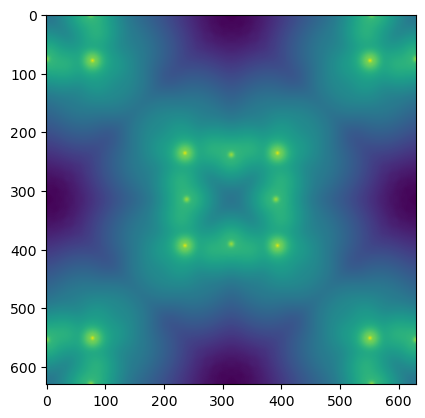

In [23]:
plt.imshow(np.log(MOF_sim.density[:,:,315]))

In [24]:
# calculate
MOF_sim.calculate_custom_FTI(three_d = True, device = 'cpu', less_memory_use=True, dtype = torch.complex128)

/home/sofya/SAXS-simulations/SAXSsimulations/create_form.py:141: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /opt/conda/conda-bld/pytorch_1670525495809/work/aten/src/ATen/native/Copy.cpp:250.)
  if FT[k,:,:].any():


## Look at the calculated 3D FT from different perspectives

In [26]:

def plt_slices_ft(simulation):
    """
    Plots central slices of the Fourier transform given all dimensions x/y/z.
    input:
        simulation : class instance with calculated attributes
    """
    vmin = myround(np.log(simulation._FTI_custom).min())
    vmax = myround(np.log(simulation._FTI_custom).max())

    fig,axs = plt.subplots(1,3,figsize = (20,10))
    ax = axs[0]
    im = ax.imshow(np.log(simulation._FTI_custom[simulation._FTI_custom.shape[0]//2+1,:,:]), cmap = 'Greys', vmin = vmin, vmax = vmax)
    ax.set_ylabel(r"$Q_z\,nm^{-1}$", fontsize = 16)
    ax.set_xlabel(r"$Q_y\,nm^{-1}$", fontsize = 16)
    ax.tick_params(labelsize = 15)
    ax = axs[1]
    im = ax.imshow(np.log(simulation._FTI_custom[:,simulation._FTI_custom.shape[1]//2+1,:]), cmap = 'Greys', vmin = vmin, vmax = vmax)
    ax.set_ylabel(r"$Q_z\,nm^{-1}$", fontsize = 16)
    ax.set_xlabel(r"$Q_x\,nm^{-1}$", fontsize = 16)
    ax.tick_params(labelsize = 15)
    ax = axs[2]
    im = ax.imshow(np.log(simulation._FTI_custom[:,:,simulation._FTI_custom.shape[2]//2+1]), cmap = 'Greys', vmin = vmin, vmax = vmax)
    ax.set_ylabel(r"$Q_y\,nm^{-1}$", fontsize = 16)
    ax.set_xlabel(r"$Q_x\,nm^{-1}$", fontsize = 16)
    ax.tick_params(labelsize = 15)
    cbar = plt.colorbar(im, ax = axs.ravel().tolist(), shrink=0.8, location = 'bottom',orientation='horizontal')
    cbar.set_label('log FFT', size=16)
    cbar.ax.tick_params(labelsize=15)
    plt.show()    

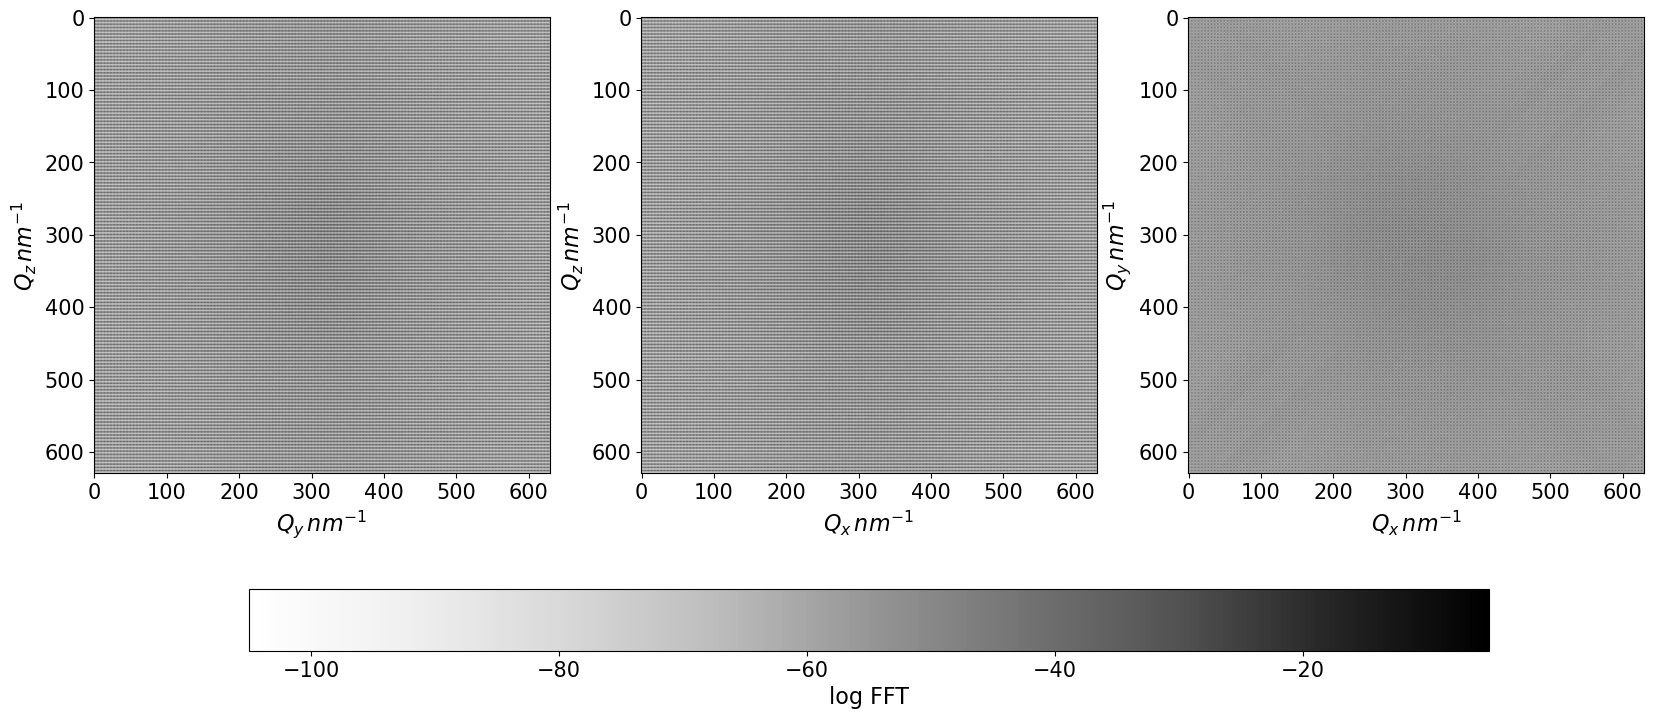

In [28]:
plt_slices_ft(MOF_sim)


## This cell creates an HDF file for the DENSITY data 

In [31]:
with h5py.File('/mnt/vsi-da/Analyses/SAXS002/2023/Sofya/MOF_new.h5', "w") as f:
    entry = f.create_group("entry")
    I = entry.create_dataset("nomalized intensity", data=cden_MOF.normalized_data['total'], dtype='f')
    I.attrs['units'] = 'nm-1'
    properties = f.create_group("properties")
    formula = properties.create_dataset('formula', data = cden_MOF.structure.formula)
    grid_shape = properties.create_dataset('grid shape', data = cden_MOF.grid_shape, dtype = 'f')
    lattice = properties.create_dataset('lattice', data = cden_MOF.lattice, dtype = 'f')
    normalization = properties.create_dataset('normalization', data = cden_MOF.normalization)
    pbc = properties.create_dataset('pbc', data = cden_MOF.structure._lattice.pbc)
    volume = properties.create_dataset('volume', data = cden_MOF.structure._lattice.volume)
    angles = properties.create_dataset('angles', data = cden_MOF.structure._lattice.angles)
    sites = f.create_group("sites")
    for i,s in enumerate(cden_MOF.structure._sites):
        group_name = 'atom_' +str(i)
        g = sites.create_group(group_name)
        g.create_dataset('species', data = s.specie.name)
        g.create_dataset('coordinates', data = s.coords, dtype = 'f')
        g.create_dataset('frac_coordinates', data = s.frac_coords, dtype = 'f')
